## Topic Modeling for Libraray Dialouges

In [113]:
#some library imports
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import pandas as pd
import os

In [5]:
# load the file
df = pd.read_csv("./data/all_chats_0330_startlineFalse.csv")
logs = df["chat"]

### The number of dialouge sessions up to date

In [114]:
len(logs)

741

### Data Class with user and lib utters and add_from_log function

In [8]:
class ChatData():
    
    def __init__(self, user_utters = None, lib_utters = None):
        
        if user_utters:
            self.user_utters = user_utters
            
        else:
            self.user_utters = []
            
        if lib_utters:
            self.lib_utters = lib_utters
            
        else:
            self.lib_utters = []
            
    def add_from_log(self, log, show_errors = False):
    # take a log and split the log into lines and add the utterences according to role    
        assert type(log) == str, "Wrong type of log, should be type of str"
        
        error_logs = []

        lines = log.split("\n")
        for line in lines:
            line_splitted = line.split(" ")
            if len(line_splitted) > 1:
                role, utter = line_splitted[0].strip(), " ".join(line_splitted[1:]).strip()
                if role == "<user>":
                    self.user_utters.append(utter)
                elif role =="<librarian>":
                    self.lib_utters.append(utter)
                else:
                    pass
            else:
                error_logs.append(line)
        if show_errors:
            print("Fllowing utterances are not added")
            print(error_logs)
            

In [59]:
data = ChatData()
for log in logs:
    data.add_from_log(log)
user_utters = data.user_utters
lib_utters = data.lib_utters
# filter all the invalid lines(with len == 0)
user_utters = [utter for utter in user_utters if len(utter)>0]
lib_utters = [utter for utter in lib_utters if len(utter)>0]

In [77]:
# data to feed the models
user_data = pd.DataFrame(user_utters)[0]
lib_data = pd.DataFrame(lib_utters)[0]

#### Exploratory Analysis

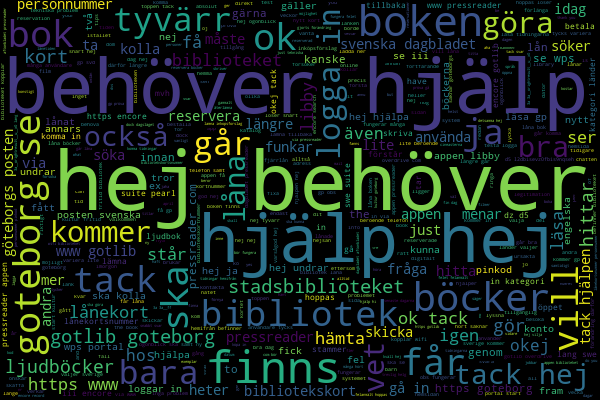

In [64]:
from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words("swedish")

# Join the different processed titles together.
long_string1 = ','.join(list(user_utters))
long_string2 = ",".join(list(lib_utters))

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords,background_color="black", width=600,
                        height=400,max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string1+long_string2)

# Visualize the word cloud
wordcloud.to_image()

In [121]:
stopwords_extra = ["librarian","user","hej","in", "tack", "ok","bok"]
stopwords = stopwords + stopwords_extra

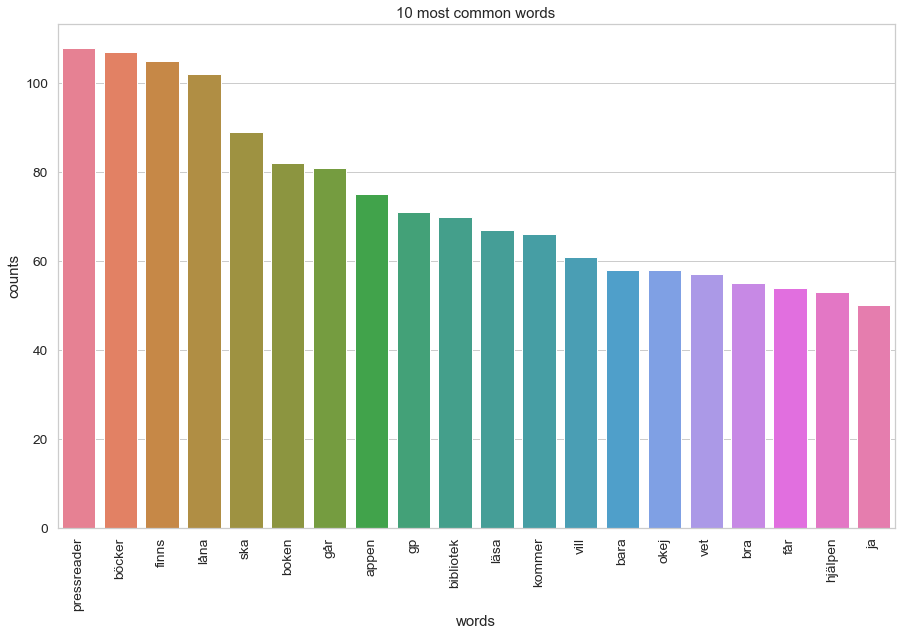

In [122]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the Swedish stop words
count_vectorizer = CountVectorizer(stop_words=stopwords)

# Fit and transform the processed utters
count_data = count_vectorizer.fit_transform(user_data)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# Initialise the tfidf vectorizer with the Swedish stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords)

# Fit and transform the processed utters
tfidf_data = tfidf_vectorizer.fit_transform(user_data)

### LDA
#### Remark: Change the number of topics and number of words yielded for each topic below

In [120]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 20

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(tfidf_data)

# Print the topics found by the LDA model
print("Topics founds via LDA-TM:")
print_topics(lda, count_vectorizer, number_words)

Topics founds via LDA-TM:

Topic #0:
toppen bra fråga svara finns dag personnummer bok heter ggr kommer stort plockas vet stadsbiblioteket två böcker kom reserverat lånat

Topic #1:
okej låna bok böcker får behöver finns förstår film stadsbiblioteket bara hejsan ska lånar göra boka thank länge bibliotek bra

Topic #2:
pressreader gp ljudböcker går läsa längre finns svenska hittar via kort biblioteket ladda fin tidningar bibliotek mvh låna hi göteborgs

Topic #3:
ok test hitta nej böcker bok göteborg to yes går kommer the do kortnummer can have tillbaka undrar jo även

Topic #4:
tack ok ja hjälpen appen svar gör ska vet logga vill pressreader bok snabbt just boken göra menar info detsamma


### Some help and visulasation for topic modeling analysis
#### Remark: adjust the value of λ to better filter out not topic specific words

In [98]:
from sklearn.decomposition import LatentDirichletAllocation

In [118]:
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tf.fit(tfidf_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [119]:
pyLDAvis.sklearn.prepare(lda_tf, tfidf_data, tfidf_vectorizer)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.204091  0.019961       1        1  13.446448
6     -0.003516 -0.062562       2        1  11.871849
4     -0.056547  0.146582       3        1  11.772700
2     -0.040237 -0.042441       4        1  11.007117
7     -0.016626 -0.009846       5        1   9.095244
1     -0.017568 -0.019123       6        1   8.885811
5      0.013137  0.024782       7        1   8.670229
3     -0.038592 -0.012168       8        1   8.531068
9     -0.022926 -0.019773       9        1   8.486100
8     -0.021217 -0.025413      10        1   8.233434, topic_info=     Category       Freq       Term      Total  loglift  logprob
2757  Default  96.000000       tack  96.000000  30.0000  30.0000
2070  Default  45.000000         ok  45.000000  29.0000  29.0000
2072  Default  20.000000       okej  20.000000  28.0000  28.0000
1408  Default  19.000000         ja  19.000000  27.0000  27.0000
1216  Default  16.000000    hjälpen  16.000000  26.0000  26.0000
...       ...        ...        ...        ...      ...      ...
917   Topic10   0.930446      fråga   5.495680   0.7209  -5.9003
850   Topic10   1.086402      finns  16.697854  -0.2354  -5.7453
377   Topic10   1.020899  bibliotek  11.532887   0.0724  -5.8075
1125  Topic10   0.913112   göteborg   5.695482   0.6664  -5.9191
333   Topic10   0.914932    behöver   8.329460   0.2883  -5.9171

[554 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1         5  0.900629         010924
5         7  0.910151     021213129a
75        1  0.331242           3000
75        6  0.331242           3000
75        7  0.331242           3000
...     ...       ...            ...
3207      2  0.667445         önskan
3208      7  0.411767         önskar
3209      6  0.989072  önskarföreslå
3213      2  0.815119          öppen
3214      6  0.377042          öppet

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 3, 8, 2, 6, 4, 10, 9])